In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [11]:

id ='1iR7pNIcSgP1YuAkr9kCS357h46TflkJ8'
print (id)

1iR7pNIcSgP1YuAkr9kCS357h46TflkJ8


In [12]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('malayalam_dev.tsv')  


In [13]:
malayalam_test=pd.read_csv('malayalam_dev.tsv',sep='\t')
malayalam_test.head()

,text,category
0,speechless 🤐. ikkaaa,not-malayalam
1,Raja sollunathu mattuthaam seyyvaa seyyunnath...,not-malayalam
2,Im Prithiviraj fan from tamilnadu... Love it,not-malayalam
3,mohanlal sir - look ..... kiddo...,Positive
4,Kandathil vech mungiya pdam Rating 1.1/5,Negative


In [14]:
id = '10qk7xVODML46fYRIACsmN5VgRVQbPK8w'
print (id)

10qk7xVODML46fYRIACsmN5VgRVQbPK8w


In [15]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('malayalam_train.tsv')  

In [16]:
malayalam_train=pd.read_csv('malayalam_train.tsv',sep='\t')
malayalam_train.head()

,text,category
0,hoo mammokka police vesham aaha anthas,Positive
1,Oru rekshayum illa...kidilam kannu nananjupoyi,Positive
2,Ikka waiting.........,Positive
3,Raju Ettante Oro Shorttum Ijathi ppwli,Positive
4,Ettan fansil netti poya aarenkilum undo? #...,Positive


In [17]:
import seaborn as sns

[Text(0, 0, 'Positive '),
 Text(0, 0, 'not-malayalam '),
 Text(0, 0, 'unknown_state '),
 Text(0, 0, 'Mixed_feelings '),
 Text(0, 0, 'Negative ')]

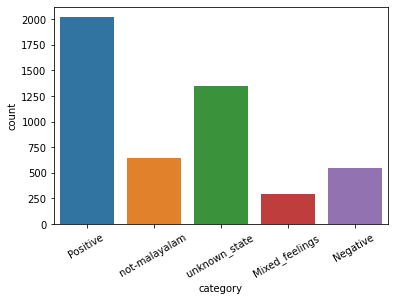

In [18]:
chart=sns.countplot(malayalam_train.category)
chart.set_xticklabels(chart.get_xticklabels(),rotation=30)

[Text(0, 0, 'not-malayalam '),
 Text(0, 0, 'Positive '),
 Text(0, 0, 'Negative '),
 Text(0, 0, 'unknown_state '),
 Text(0, 0, 'Mixed_feelings ')]

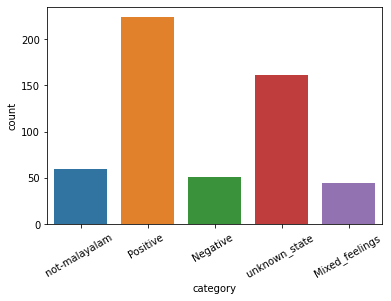

In [19]:
chart=sns.countplot(malayalam_test.category)
chart.set_xticklabels(chart.get_xticklabels(),rotation=30)

In [20]:
import re
import string
import nltk
from bs4 import BeautifulSoup 

In [21]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [22]:
tex='Waiting to see mammukaas undaa 🤣'
print(remove_emoji(tex))

Waiting to see mammukaas undaa 


In [23]:
def strip_html(text):
  soup=BeautifulSoup(text, "html.parser")
  return soup.get_text()
def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)
def remove_symbols(text):
  return re.sub('[/w]','',text)
def remove_mentio(text):
  return re.sub(r"(?:\@|https?\://)\S+", "", text)

In [24]:
def clean(text):
  text=strip_html(text)
  text=remove_mentio(text)
  text=remove_between_square_brackets(text)
  text=remove_emoji(text)
  text=remove_symbols(text)
  return text

In [25]:
malayalam_train['text']=malayalam_train['text'].apply(clean)
malayalam_test['text']=malayalam_test['text'].apply(clean)

In [26]:
x_train=malayalam_train['text']
y_train=malayalam_train['category']

In [27]:
x_test=malayalam_test['text']
y_test=malayalam_test['category']

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(x_train)

In [29]:
malayalam_train.head()

,text,category
0,hoo mammokka police vesham aaha anthas,Positive
1,Oru rekshayum illa...kidilam kannu nananjupoyi,Positive
2,Ikka aiting.........,Positive
3,Raju Ettante Oro Shorttum Ijathi ppli,Positive
4,Ettan fansil netti poya aarenkilum undo? #...,Positive


In [30]:
len(vect.get_feature_names())

12782

In [31]:
X_train_vect=vect.transform(x_train)
X_train_vect

<4851x12782 sparse matrix of type '<class 'numpy.int64'>'
	with 37584 stored elements in Compressed Sparse Row format>

In [32]:
max_length=192
classes=y_train.unique().tolist()


In [33]:
def trans_y(y_train):
  y_train_label=[]
  for label in y_train:
    y_train_label.append(classes.index(label))
  return y_train_label

In [34]:
y_train_label=trans_y(y_train)

In [35]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=1, multi_class='ovr')
model.fit(X_train_vect,y_train_label)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
y_test_label=trans_y(y_test)

In [37]:
from sklearn.metrics import roc_auc_score, accuracy_score
prediction=model.predict(vect.transform(x_test))

prediction_train=model.predict(X_train_vect)

In [38]:
accuracy_score(y_train_label,prediction_train)

0.9595959595959596

In [39]:
prediction_train

array([0, 0, 0, ..., 3, 4, 3])

In [40]:
accuracy_score(y_test_label,prediction)

0.6851851851851852

In [41]:
import matplotlib.pyplot as plt

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
confusion_m=confusion_matrix(y_test_label,prediction)

confusion_df=pd.DataFrame(confusion_m,index=[i for i in range(1,6)],columns=[i for i in range(1,6)])
print(confusion_m)

[[175  11  27   5   6]
 [  7  43   9   0   1]
 [ 31   7 118   0   5]
 [ 23   1   7   9   4]
 [ 15   0  10   1  25]]


<function matplotlib.pyplot.show>

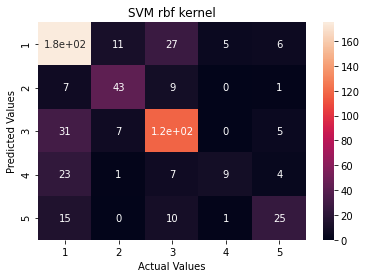

In [44]:
plt.figure
sns.heatmap(confusion_df, annot=True)
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')
plt.title('SVM rbf kernel')
plt.show

In [45]:
from google.colab import files
uploaded = files.upload()

In [46]:
import io
m_test = pd.read_csv(io.BytesIO(uploaded['malayalam_test - malayalam_test.csv']))

KeyError: ignored

In [37]:
M_test_x=m_test['text'].apply(clean)


In [38]:
a=model.predict(vect.transform(M_test_x))

In [39]:
pre_m=[]
for i in a:
  pre_m.append(classes[i])

In [40]:
m_test['label']=pre_m
m_test.head()

,id,text,label
0,ml_sen_1,Bollywood film Newton inte remake aano?,unknown_state
1,ml_sen_2,endukond viewrs koodunnilla ?? ippozhum 2.8m a...,unknown_state
2,ml_sen_3,Mara paazhu mega mairananil ninnum ethil koodu...,Negative
3,ml_sen_4,Video nay cang xem cang thit,unknown_state
4,ml_sen_5,Sunny chechiye kaanan vannathu njan maathram aano,Positive


In [41]:
m_test.to_csv('Deepesh_malayalam.tsv',sep='\t')

In [42]:
import sklearn

In [43]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, recall_score, precision_score, make_scorer

In [44]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [45]:
svm = SVC(probability=True, kernel="linear", class_weight="balanced",)

grid_svm = GridSearchCV(svm,
                    param_grid = {'C': [0.01, 0.1, 1],'gamma' :[.01,.1,1,10]}, 
                    cv = 5,
                    scoring='accuracy',
                    verbose=1,   
                    n_jobs=-1) 


grid_svm.fit(X_train_vect, y_train_label)
grid_svm.score(vect.transform(x_test), y_test_label)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.8min finished


0.6370370370370371

In [46]:
model=grid_svm.best_estimator_ 
 
pred_test=model.predict(vect.transform(x_test))
accuracy_score(y_test_label,pred_test)

0.6370370370370371

In [47]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=1)
model.fit(X_train_vect,y_train_label)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
y_test_label=trans_y(y_test)

In [49]:

prediction=model.predict(vect.transform(x_test))

prediction_train=model.predict(X_train_vect)

In [50]:
accuracy_score(y_train_label,prediction_train)

0.9775304061018347

In [51]:
prediction_train

array([0, 0, 0, ..., 3, 4, 3])

In [52]:
accuracy_score(y_test_label,prediction)

0.6777777777777778

In [54]:
from sklearn.linear_model import Perceptron

In [55]:
model=Perceptron()
model.fit(X_train_vect,y_train_label)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [56]:

prediction=model.predict(vect.transform(x_test))

prediction_train=model.predict(X_train_vect)

In [57]:
accuracy_score(y_train_label,prediction_train)

0.9946402803545661

In [58]:
prediction_train

array([0, 0, 0, ..., 3, 4, 3])

In [59]:
accuracy_score(y_test_label,prediction)

0.6148148148148148